In [2]:
import matplotlib.pyplot as plt
# Create labels for the x-axis (temperature ranges)
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import sys
sys.path.insert(0,'/cluster/work/climate/dnikolo/n2o')
from Glaciation_time_estimator.Auxiliary_func.config_reader import read_config
from Glaciation_time_estimator.Data_postprocessing.Job_result_fp_generator import generate_tracking_filenames
import seaborn as sns

In [3]:
config=read_config('/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/config_half.yaml')
t_deltas = config['t_deltas']
agg_fact = config['agg_fact']
min_temp_array, max_temp_array = config['min_temp_arr'],config['max_temp_arr']
folder_name=f"{config['start_time'].strftime(config['time_folder_format'])}_{config['end_time'].strftime(config['time_folder_format'])}"

In [4]:
ice_cont_crit_frac=0.05

Load data

In [5]:
def Extract_array_from_df(series:pd.Series):
    if series.empty:
        return None
    return np.stack(series.values)

In [6]:

# Initialize an empty list to store the individual dataframes
cloud_properties_df_list = []

# Iterate over each temperature range
for i in range(len(min_temp_array)):
    cloud_properties_df_list.append([])
    min_temp = min_temp_array[i]
    max_temp = max_temp_array[i]
    
    # Iterate over each pole
    for pole in config["pole_folders"]:
        # Construct the file path
        fp = os.path.join(
            config['postprocessing_output_dir'],
            pole,
            folder_name,
            f"Agg_{agg_fact:02}_T_{abs(round(min_temp)):02}_{abs(round(max_temp)):02}.parquet"
        )
        
        # Read the parquet file into a dataframe
        df = pd.read_parquet(fp)
        
        # Add columns for min_temp, max_temp, and pole
        df['min_temp'] = min_temp
        df['max_temp'] = max_temp
        df['pole'] = pole
        df['Hemisphere'] = "South" if pole == "sp" else "North"
        df['Lifetime [h]'] = df['track_length'] / pd.Timedelta(hours=1)
        
        # Append the dataframe to the sublist
        cloud_properties_df_list[i].append(df)

# Combine all dataframes into a single dataframe
combined_df = pd.concat([df for sublist in cloud_properties_df_list for df in sublist], ignore_index=True)

In [10]:
def normalize_IF_hist(row):
    lst = row['ice_frac_hist']
    normalized_length = 100
    original_indices = np.linspace(0, 1, len(lst))
    target_indices = np.linspace(0, 1, normalized_length)
    return np.interp(target_indices, original_indices, lst)

def max_normalize_IF_hist(row):
    lst = row['ice_frac_hist']
    max_val = np.max(lst)
    normalized_length=100
    if max_val == 0:
        normalized_list = np.zeros(normalized_length)
        max_idx = None
    else:
        max_idx = np.argmax(lst)
        original_indices = np.linspace(0, max_idx, len(lst[:max_idx + 1]))
        target_indices = np.linspace(0, max_idx, normalized_length)
        normalized_list = np.interp(target_indices, original_indices, lst[:max_idx + 1])
        normalized_list = np.pad(normalized_list, (0, normalized_length - len(normalized_list)), constant_values=np.nan)
    return normalized_list, max_idx

In [11]:
norm_IF_hist_list= []
max_norm_IF_hist_list =[]
Timesteps_to_max_list= []
for i, row in combined_df.iterrows():
    if i%10000==0:
        print(i/10000)
    max_norm_IF_hist, Timesteps_to_max =max_normalize_IF_hist(row)
    norm_IF_hist_list.append(normalize_IF_hist(row))
    max_norm_IF_hist_list.append(max_norm_IF_hist)
    Timesteps_to_max_list.append(Timesteps_to_max)
combined_df["Timesteps_to_max"] = Timesteps_to_max_list
combined_df['max_norm_IF_hist'] = max_norm_IF_hist_list
combined_df['norm_IF_hist'] = norm_IF_hist_list

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0


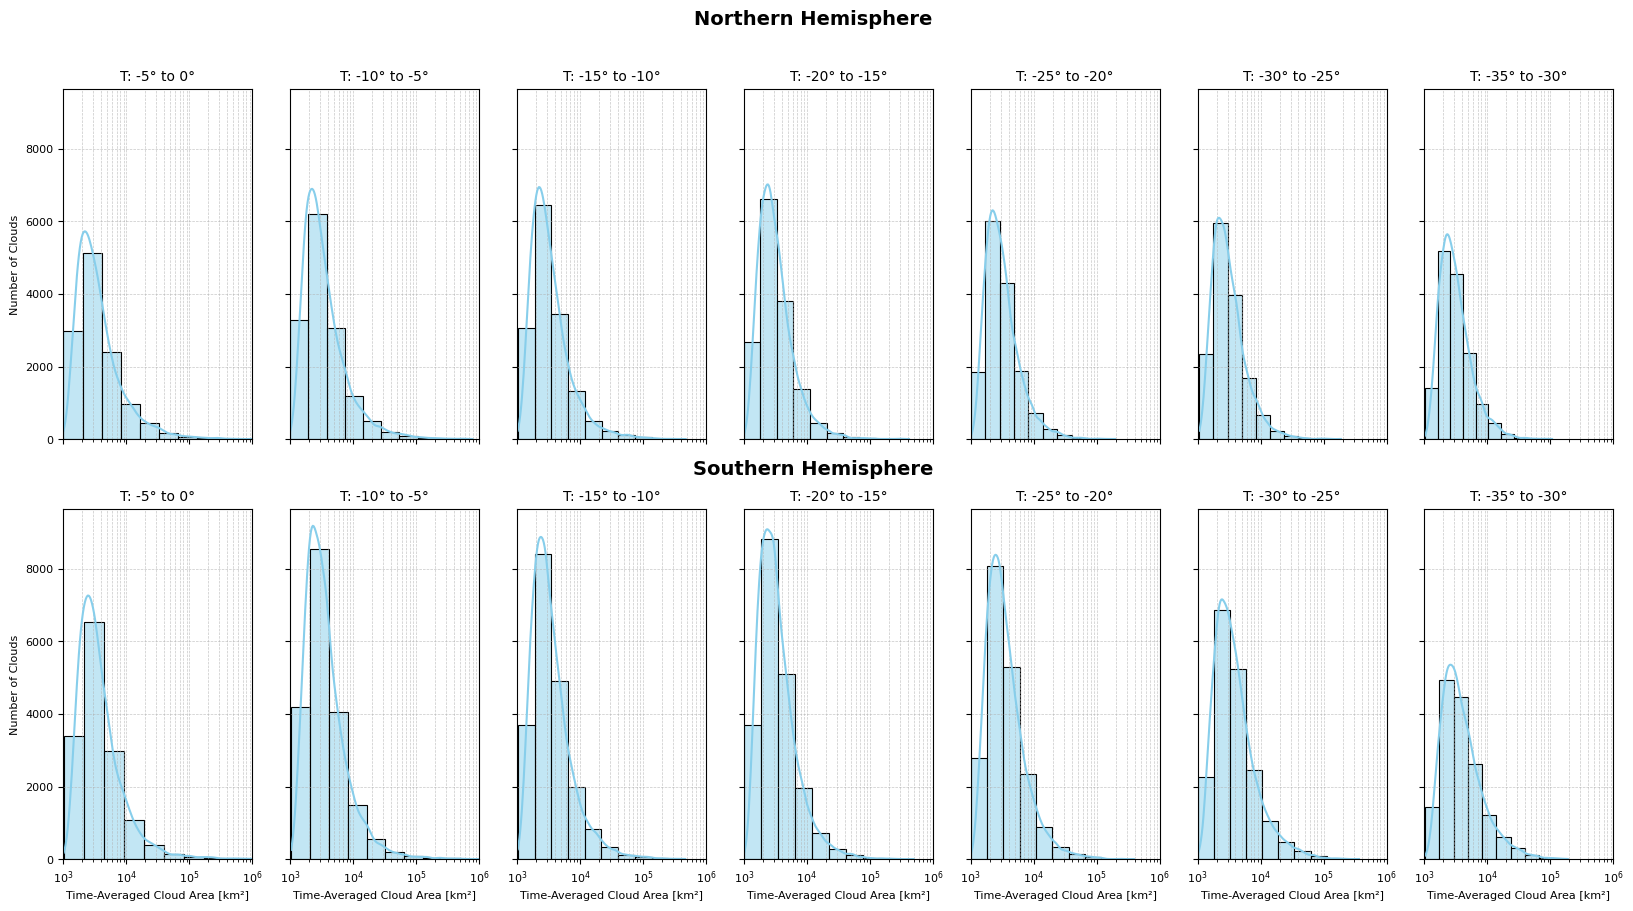

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of poles and temperature ranges
num_poles = len(config["pole_folders"])
num_temps = len(min_temp_array)

# Create a figure with subplots
fig, axes = plt.subplots(num_poles, num_temps, figsize=(20, 10), sharex=True, sharey=True)

# Iterate through temperature ranges and pole folders
for t_ind in range(num_temps):
    for pole_ind in range(num_poles):
        ax = axes[pole_ind, t_ind]  # Select the appropriate subplot
        df = cloud_properties_df_list[t_ind][pole_ind]
        min_temp = min_temp_array[t_ind]
        max_temp = max_temp_array[t_ind]

        # Plot histogram
        sns.histplot(
            x=df["avg_size[km]"], 
            bins=10, 
            kde=True, 
            log_scale=[True, False], 
            color='skyblue', 
            edgecolor='black', 
            linewidth=0.8, 
            ax=ax
        )

        # Set title for each subplot
        hemisphere= "Southern hemisphere" if pole_ind == 1  else  "Northern hemisphere"
        ax.set_title(f"T: {min_temp}\u00B0 to {max_temp}\u00B0", fontsize=10)

        # Customize x-axis and y-axis labels
        if pole_ind == num_poles - 1:  # Bottom row
            ax.set_xlabel("Time-Averaged Cloud Area [km²]", fontsize=8)
        if t_ind == 0:  # First column
            ax.set_ylabel("Number of Clouds", fontsize=8)

        # Set x-axis scale and grid
        ax.set_xlim(1e3, 1e6)
        ax.set_xscale('log')
        ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        
        # Customize ticks
        ax.tick_params(axis='both', which='major', labelsize=8)

fig.text(0.5, 0.95, "Northern Hemisphere", ha='center', va='center', fontsize=14, weight='bold')
fig.text(0.5, 0.50, "Southern Hemisphere", ha='center', va='center', fontsize=14, weight='bold')

# Adjust layout
# fig.tight_layout(rect=[0, 0, 1, 0.92]) 
# plt.subplots_adjust(top=0.9, hspace=0.4)  # Increase top margin and spacing between rows
# Adjust layout to avoid overlapping
# plt.tight_layout()

# Save the figure
filename="/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/size_hist_temp_subplots"
plt.savefig(filename+'.png', dpi=400)
plt.savefig(filename+'.pdf', dpi=400)

# Show the plot
plt.show()

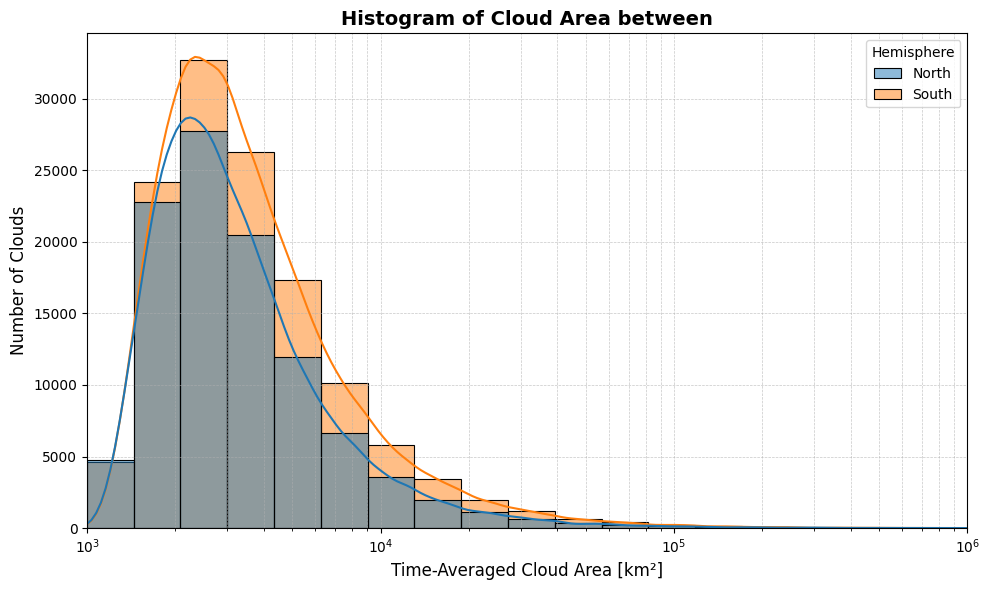

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x="avg_size[km]",hue='Hemisphere',bins=20, kde=True, log_scale=[True, False], color='skyblue', edgecolor='black', linewidth=0.8)
# plt.legend(title='Hemisphere', loc='upper right', labels=['North', 'South'])
# Labels and title
plt.xlabel("Time-Averaged Cloud Area [km²]", fontsize=12)
plt.ylabel("Number of Clouds", fontsize=12)
plt.title("Histogram of Cloud Area between", fontsize=14, fontweight='bold')

# Customize x-axis
plt.xlim(1e3, 1e6)
plt.xscale('log')
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Save the figure
plt.tight_layout()  # Adjust layout to avoid clipping
# plt.savefig('/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/size_hist_T_5_0_np.png', dpi=400)
filename="/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/size_hist_by_pole"
plt.savefig(filename+'.png', dpi=400)
plt.savefig(filename+'.pdf', dpi=400)

# Show the plot
plt.show()


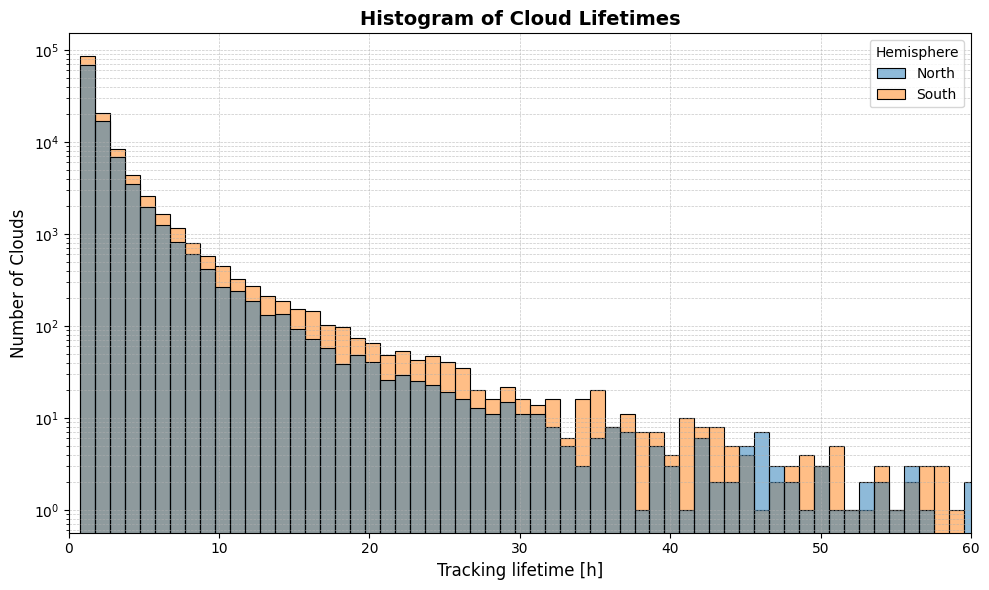

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(data=combined_df, x="Lifetime [h]",hue='Hemisphere',binwidth=1, color='skyblue',log_scale=[False, True], edgecolor='black', linewidth=0.8)
# plt.legend(title='Hemisphere', loc='upper right', labels=['North', 'South'])
# Labels and title
plt.xlabel("Tracking lifetime [h]", fontsize=12)
plt.ylabel("Number of Clouds", fontsize=12)
plt.title("Histogram of Cloud Lifetimes", fontsize=14, fontweight='bold')

# Customize x-axis
# plt.xlim(1e3, 1e6)
plt.yscale('log')
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(left=0, right=60)
# Save the figure
plt.tight_layout()  # Adjust layout to avoid clipping
# plt.savefig('/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/size_hist_T_5_0_np.png', dpi=400)
filename="/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/lifetime_hist_by_pole"
plt.savefig(filename+'.png', dpi=400)
plt.savefig(filename+'.pdf', dpi=400)

# Show the plot
plt.show()

In [12]:
def check_cloud(row, params):
    norm_ice_frac_hist = row['norm_IF_hist']
    if (max(norm_ice_frac_hist) >=params['crit_max_IF']) and row['Timesteps_to_max'] >=params['min_time_to_max'] and row['track_length']>=params['crit_lifetime'] and (max(norm_ice_frac_hist) >= norm_ice_frac_hist[:10].mean()+params['min_delta_IF']):
        return True
    return False



In [13]:
from itertools import product
crit_max_IF_vals = np.arange(0.1,0.91,0.2)
crit_lifetime_vals = [timedelta(minutes=45), timedelta(hours=1), timedelta(hours=2) ,timedelta(hours=3)]
min_delta_IF_vals = [-1,0,0.3,0.6,0.9]
min_time_to_max_vals = [0,4,8]
print(crit_max_IF_vals, crit_lifetime_vals, min_delta_IF_vals)

all_combinations = product(crit_max_IF_vals, crit_lifetime_vals, min_delta_IF_vals, min_time_to_max_vals)

# Create a dataframe
params_df = pd.DataFrame(all_combinations, columns=['crit_max_IF', 'crit_lifetime', 'min_delta_IF', 'min_time_to_max'])


[0.1 0.3 0.5 0.7 0.9] [datetime.timedelta(seconds=2700), datetime.timedelta(seconds=3600), datetime.timedelta(seconds=7200), datetime.timedelta(seconds=10800)] [-1, 0, 0.3, 0.6, 0.9]


In [14]:
from functools import partial
from multiprocessing import Pool

In [15]:
def check_param_comb(row):
    # print(f"It")
    # check_params = {
    #     'crit_max_IF': row["crit_max_IF"],
    #     'crit_lifetime': row["crit_lifetime"],
    #     'min_delta_IF': row["min_delta_IF"],
    #     'min_time_to_max': row["min_time_to_max"]}
    part_check_cloud = partial(check_cloud, params=row)
    combined_df['Filter_check'] = combined_df.apply(part_check_cloud, axis=1)
    return combined_df['Filter_check'].sum()

In [16]:
with Pool(8) as pool:
    n_passing_clouds = pool.map(check_param_comb, [row for _, row in params_df.iterrows()])

# Assigning results back to `params_df`
params_df['N_passing_clouds'] = n_passing_clouds

print(params_df)

ItItItItItItItIt







It
It
It
It
It
It
It
It
It
It
It
It
ItIt

It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
It
     crit_max_IF   crit_lifetime  min_delta_IF  min_time_to_max  \
0            0.1 0 days 00:45:00 

In [17]:
# Create pairs of variables for axes
params_df["Min Lifetime [h]"] = params_df["crit_lifetime"]/ timedelta(hours=1)
params_df['Frac passing clouds'] = params_df["N_passing_clouds"]/len(combined_df) *100
params_df["crit_max_IF"] = round(params_df["crit_max_IF"],2)
params_df["min_time_to_max [h]"] = params_df["min_time_to_max"]/4

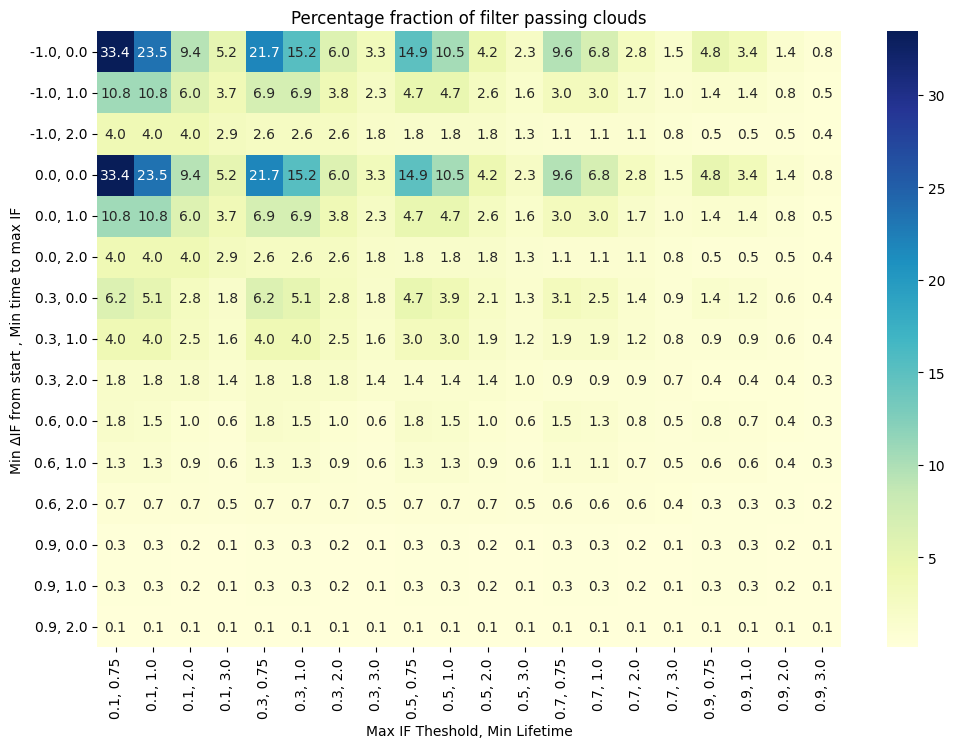

In [18]:

params_df["x_pair"] = params_df["crit_max_IF"].astype(str) + ", " + params_df["Min Lifetime [h]"].astype(str)
params_df["y_pair"] = params_df["min_delta_IF"].astype(str) + ", " + params_df["min_time_to_max [h]"].astype(str)

# Pivot table for heatmap
heatmap_data = params_df.pivot_table(
    index="y_pair",
    columns="x_pair",
    values="Frac passing clouds",
    aggfunc="mean"
)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".01f", cmap="YlGnBu")
plt.title("Percentage fraction of filter passing clouds")
plt.xlabel("Max IF Theshold, Min Lifetime")
plt.ylabel("Min ΔIF from start , Min time to max IF")
filename="/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/frac_filter_passing_clouds"
plt.savefig(filename+'.png', dpi=400)
plt.savefig(filename+'.pdf', dpi=400)
plt.show()

In [19]:
combined_df.keys()

Index(['is_liq', 'is_mix', 'is_ice', 'max_water_frac', 'max_ice_fraction',
       'avg_size[km]', 'max_size[km]', 'min_size[km]', 'avg_size[px]',
       'max_size[px]', 'min_size[px]', 'track_start_time', 'track_length',
       'glaciation_start_time', 'glaciation_end_time', 'avg_lat', 'avg_lon',
       'start_ice_fraction', 'end_ice_fraction', 'ice_frac_hist', 'lat_hist',
       'lon_hist', 'size_hist_km', 'min_temp', 'max_temp', 'pole',
       'Hemisphere', 'Lifetime [h]', 'Timesteps_to_max', 'max_norm_IF_hist',
       'norm_IF_hist'],
      dtype='object')

(1000.0, 1000000.0)

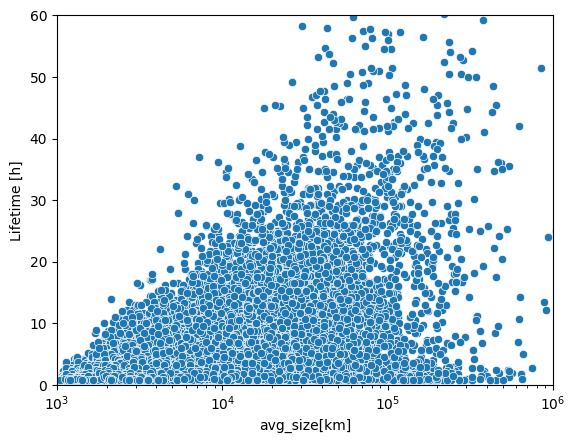

In [20]:
sns.scatterplot(data=combined_df, x= "avg_size[km]", y = "Lifetime [h]")
plt.xscale('log')
plt.ylim(0,60)
plt.xlim(1e3,1e6)

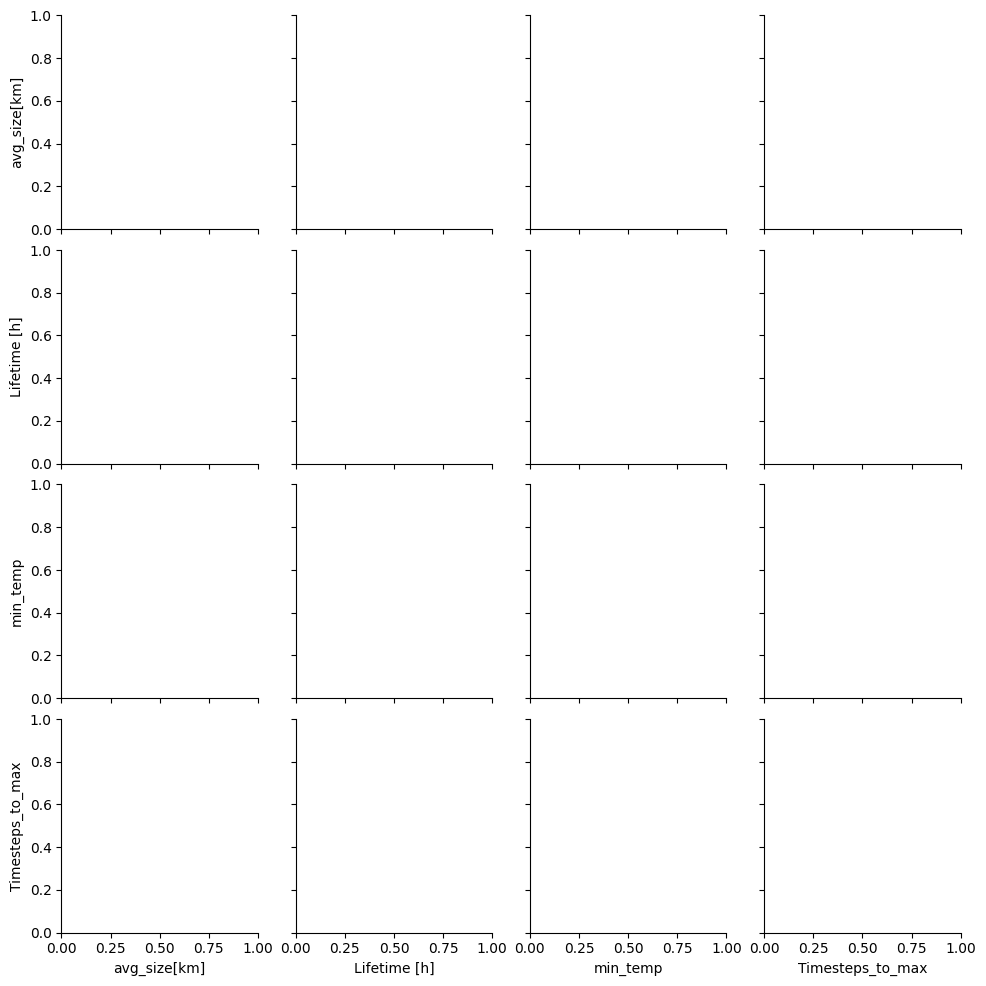

In [21]:
clean_df = combined_df[["avg_size[km]", "Lifetime [h]", "min_temp","Timesteps_to_max"]]
sns.PairGrid(data=clean_df)

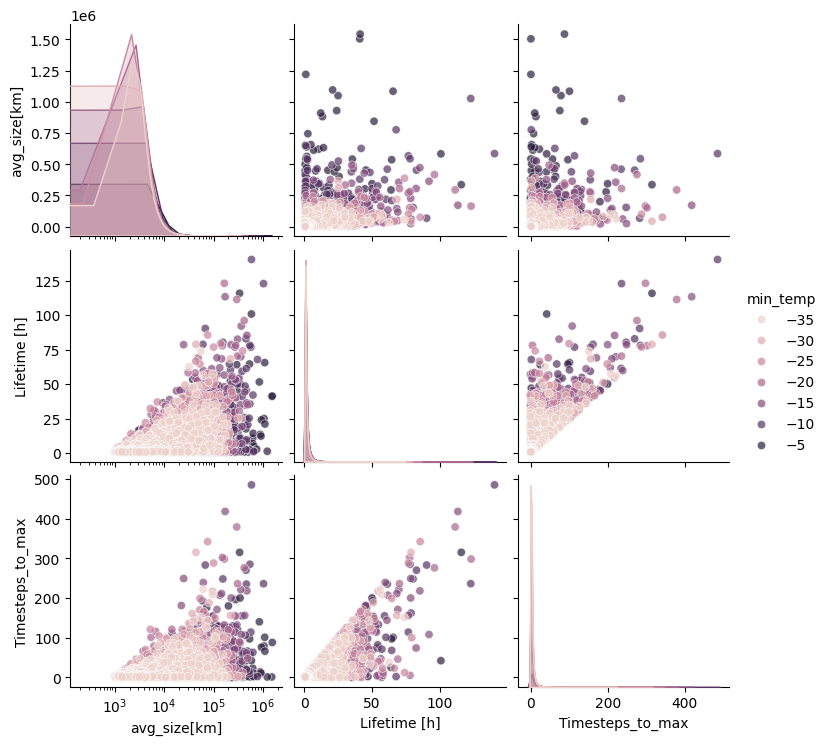

In [ ]:

# Assuming 'clean_df' is the DataFrame containing the columns
pairplot = sns.pairplot(clean_df, hue="min_temp", plot_kws={'alpha': 0.7})

# Apply a logarithmic scale to the x-axis of the "avg_size[km]" variable
for ax in pairplot.axes.flatten():
    # Apply log scale to 'avg_size[km]' on the x-axis
    if ax.get_xlabel() == 'avg_size[km]':
        ax.set_xscale('log')

# Get indices of the diagonal axes
# diagonal_indices = np.diag_indices_from(pairplot.axes)

# # Apply log scale to the y-axis of the diagonal plots (Lifetime [h] vs Lifetime [h], Timesteps_to_max vs Timesteps_to_max)
# for i, j in zip(*diagonal_indices):
#     ax = pairplot.axes[i, j]
#     ax.set_yscale('log')
filename="/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimator/Result_graphs/pairplot_all"
plt.savefig(filename+'.png', dpi=400)
plt.savefig(filename+'.pdf', dpi=400)
plt.show()

In [34]:
clean_df = combined_df[["avg_size[km]", "Lifetime [h]", "min_temp", "Timesteps_to_max", "max_ice_fraction", "avg_lat"]].sample(50000)

<Axes: >

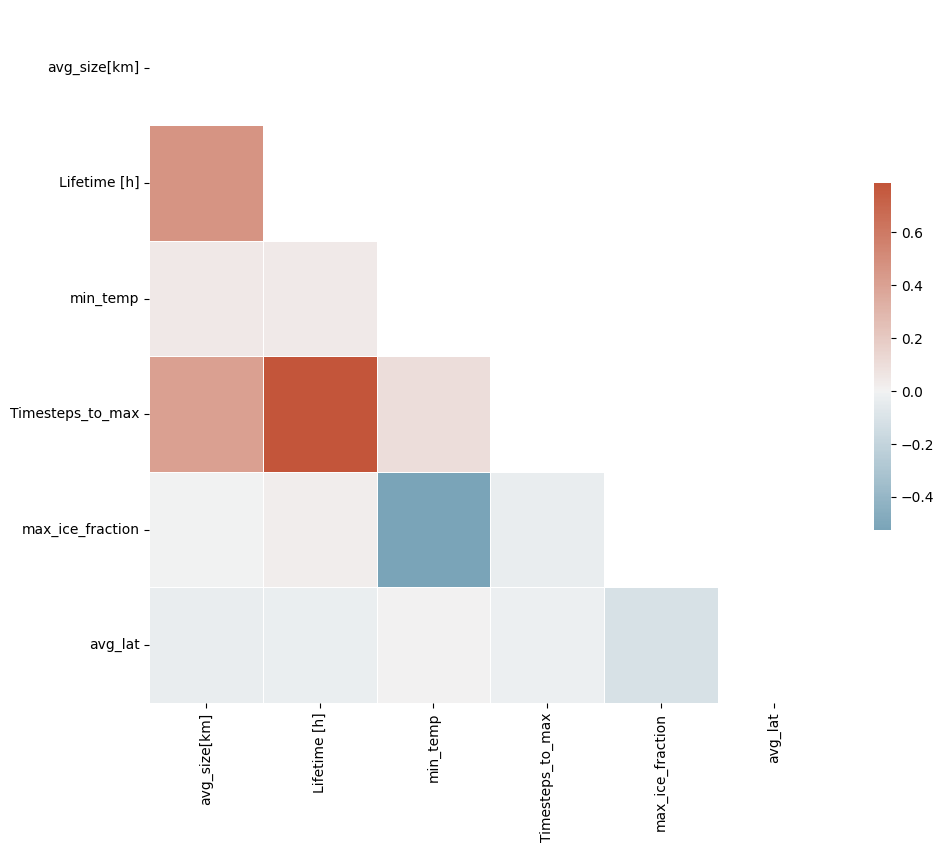

In [36]:
# Compute the correlation matrix
corr = clean_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5, cbar_kws={"shrink": .5})

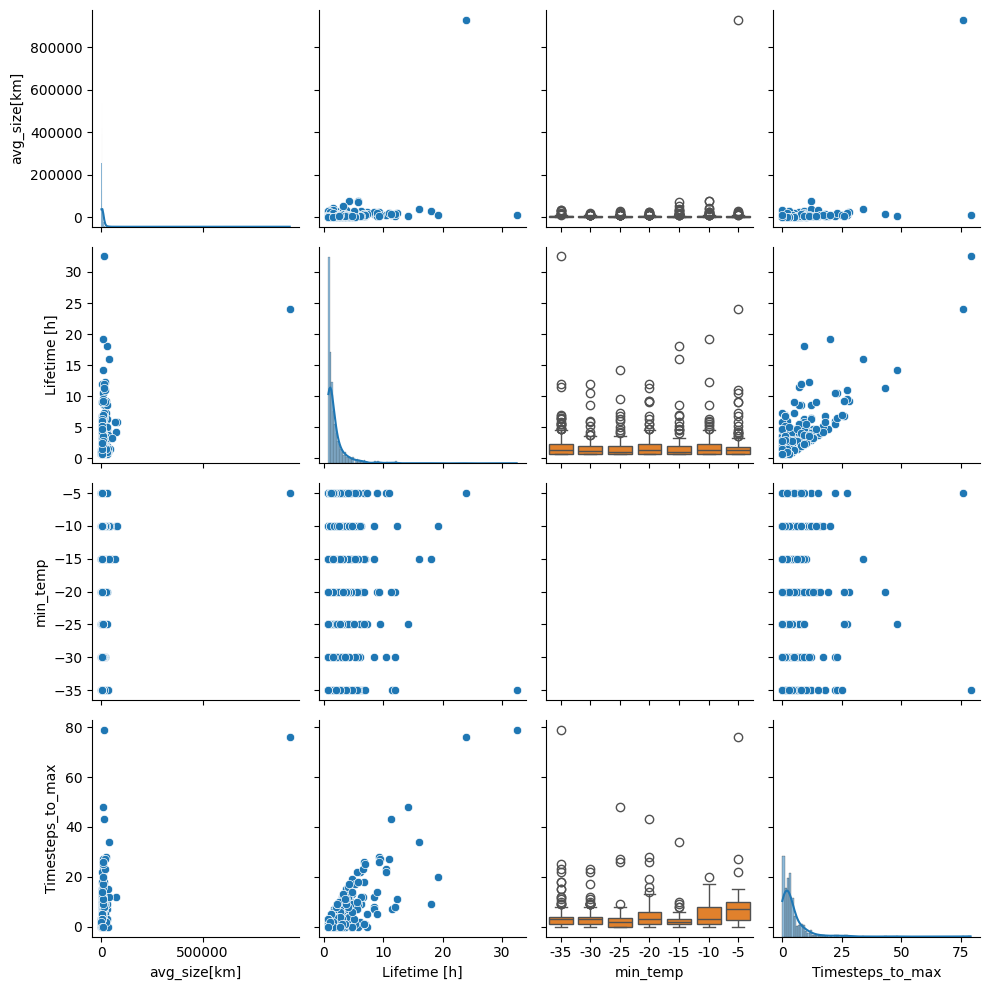

In [25]:
# Define the dataset


# Create the PairGrid
g = sns.PairGrid(clean_df)

# Define how to plot each subplot
g.map_upper(sns.scatterplot)  # Scatter plot for the upper triangle
g.map_lower(sns.scatterplot)  # Scatter plot for the lower triangle
g.map_diag(sns.histplot, kde=True)  # Histogram with KDE for the diagonal

# Replace subplots with `min_temp` as one of the axes with box plots
for i, var_i in enumerate(g.x_vars):
    for j, var_j in enumerate(g.y_vars):
        if var_i == "min_temp": #or var_j == "min_temp":
            if i != j:  # Avoid diagonal plots
                ax = g.axes[j, i]  # Get the corresponding axes
                sns.boxplot(x=clean_df[var_i], y=clean_df[var_j], ax=ax)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [26]:
def half_filter(row):
    IF = np.array(row['norm_IF_hist'])
    if IF[:50].mean() + 0.1 < IF[50:].mean()
        

SyntaxError: expected ':' (2769513950.py, line 3)

In [ ]:
half_filter(combined_df.iloc[0])

100


In [ ]:
(combined_df['is_liq']& combined_df['is_mix'] & combined_df['is_ice']).astype(bool).sum(axis=0)/len(combined_df)

0.010378486657773288

KeyboardInterrupt: 

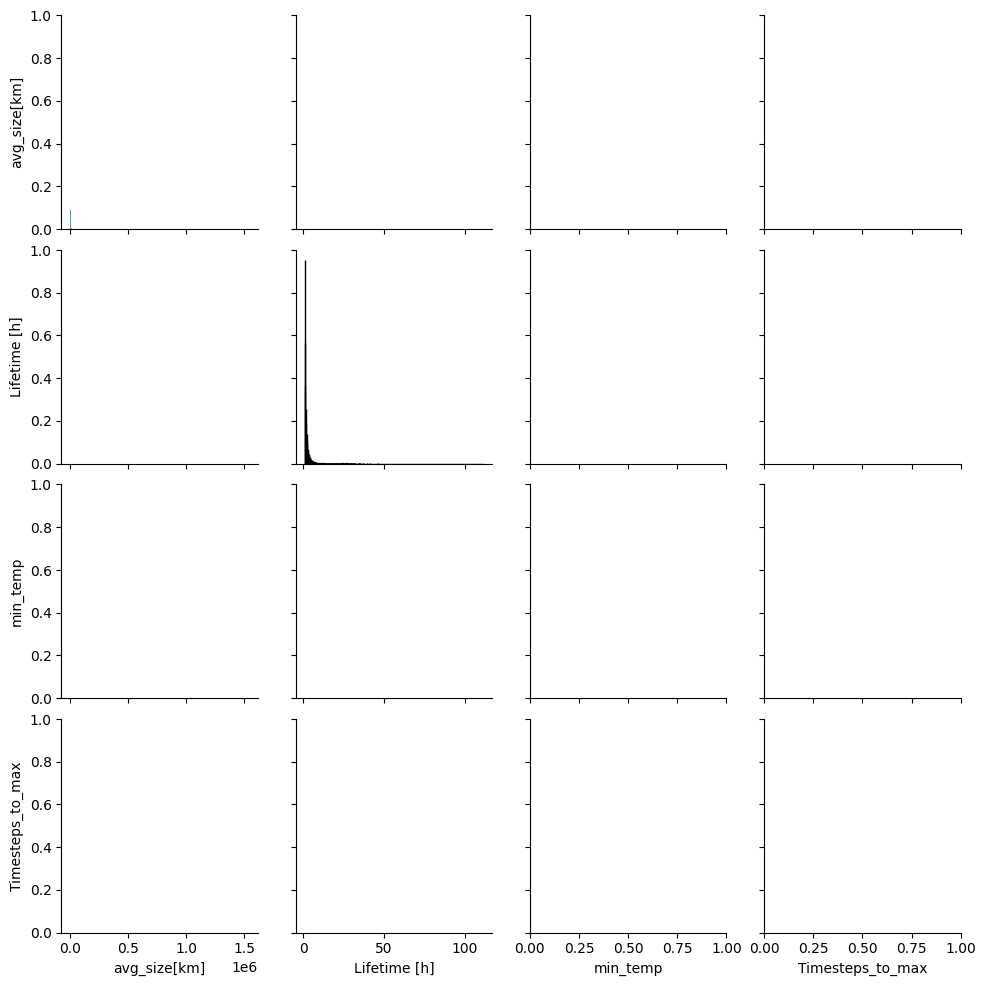

In [ ]:
clean_df = combined_df[["avg_size[km]", "Lifetime [h]", "min_temp","Timesteps_to_max"]]
sns.pairplot(data=clean_df)

In [ ]:
glaciation_counter_strong=0
cloud_count=np.empty((len(config['pole_folders']),len(min_temp_array)))
glaciation_counter_strong=np.zeros(len(config['pole_folders']))
for i in range(len(min_temp_array)):
    for j in range(len(config['pole_folders'])):
        min_temp=min_temp_array[i]
        max_temp=max_temp_array[i]
        df=cloud_properties_df_list[i][j]
        total=df['is_liq']+df['is_mix']+df['is_ice']
        total=df['is_liq'].size
        glaciation_counter_strong[j]+=(df['is_liq']& df['is_mix'] & df['is_ice']).astype(bool).sum(axis=0)
        cloud_count[j,i]=total
        

In [ ]:
glaciation_counter_temp_agg_1=np.zeros(len(min_temp_array))
for i in range(len(min_temp_array)):
    min_temp=min_temp_array[i]
    max_temp=max_temp_array[i]
    df=cloud_properties_df_list[i][0]
    glaciation_counter_temp_agg_1[i]+=(df['is_liq']& df['is_mix'] & df['is_ice']).astype(bool).sum(axis=0)
    df=cloud_properties_df_list[i][1]
    glaciation_counter_temp_agg_1[i]+=(df['is_liq']& df['is_mix'] & df['is_ice']).astype(bool).sum(axis=0)


NameError: name 'agg_fact_list' is not defined

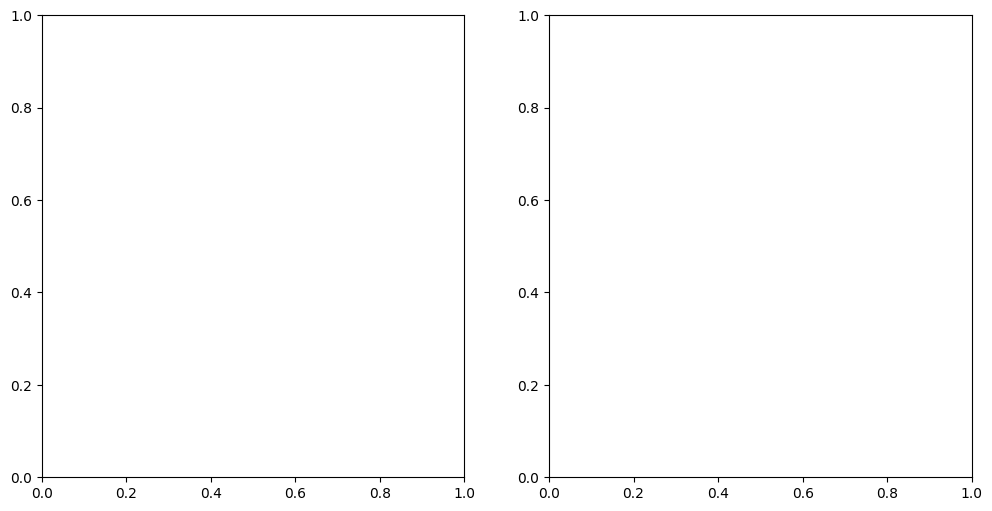

In [ ]:
from datetime import timedelta
start_ice_content_list=[]
higher_final_IF_counter_temp=np.zeros(len(min_temp_array))
labels = [f"{min_temp_array[i]} to {max_temp_array[i]}" for i in range( len(min_temp_array))]
# Create a figure and two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
for i in range(len(min_temp_array)-1,-1,-1):
    agg_fact=agg_fact_list[j]
    min_temp=min_temp_array[i]
    max_temp=max_temp_array[i]
    df=cloud_properties_df_list[i][np.where(agg_fact_list==3)[0][0]]
    # print(df["track_length"]>)
    start_ice_content = Extract_array_from_df(df["start_ice_fraction"][(df["max_ice_fraction"]>ice_cont_crit_frac) & (df["track_length"]>timedelta(minutes=60))])
    if start_ice_content is not None:
        end_ice_content = Extract_array_from_df(df["end_ice_fraction"][(df["max_ice_fraction"]>ice_cont_crit_frac) & (df["track_length"]>timedelta(minutes=60))])
        higher_final_IF_counter_temp[i]=(start_ice_content.mean(axis=1)<end_ice_content.mean(axis=1)).sum()
        bins=np.linspace(0,0.2,10)
        ax1.hist(np.var(start_ice_content,axis=1),bins=bins,label=labels[i])
        ax2.hist(np.var(start_ice_content,axis=1),bins=bins,label=labels[i])
ax1.set_xlim(0,0.2)
ax2.set_xlim(0,0.2)
ax1.set_title("First 1h")
ax2.set_title("Last 1h")
ax1.set_xlabel("Variance")
ax2.set_xlabel("Variance")
ax1.set_ylabel("Cloud number")
ax2.set_ylabel("Cloud number")
fig.suptitle("Variance of ice concentraion at start and end of track")
ax1.legend()
ax2.legend()
plt.savefig('/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimatior/Result_graphs/ice_content_variance_hist.png', dpi=400)
higher_final_IF_counter_temp

In [ ]:
timedelta(minutes=45)/2

datetime.timedelta(seconds=1350)

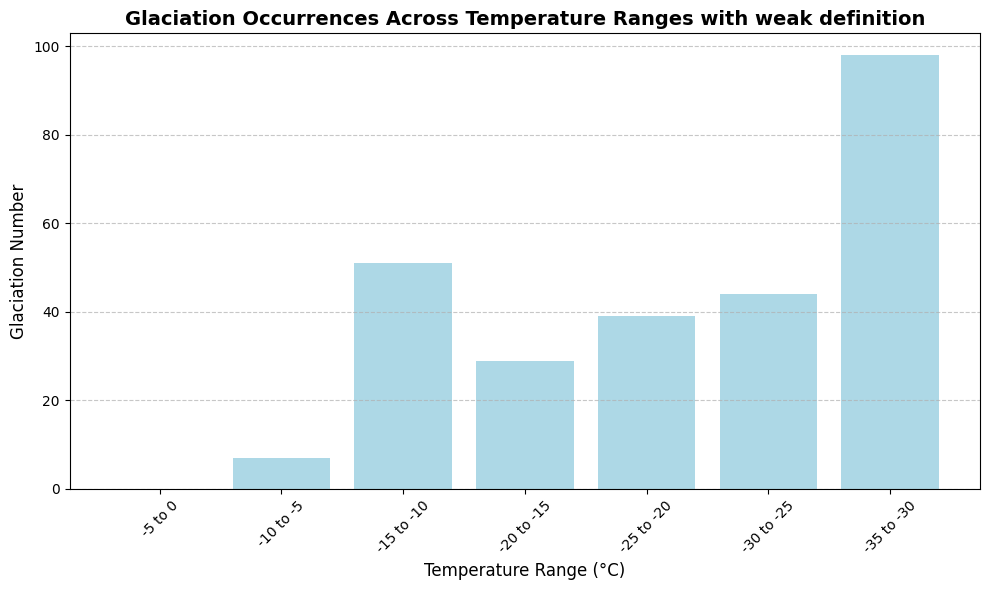

In [ ]:
# Create labels for the x-axis (temperature ranges)
labels = [f"{min_temp_array[i]} to {max_temp_array[i]}" for i in range( len(min_temp_array))]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(labels, higher_final_IF_counter_temp, color='lightblue', label="N glaciations")

# Add title and labels
plt.title('Glaciation Occurrences Across Temperature Ranges with weak definition', fontsize=14, fontweight='bold')
plt.xlabel('Temperature Range (°C)', fontsize=12)
plt.ylabel('Glaciation Number', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add gridlines for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format y-axis to show only integer values
plt.gca().yaxis.get_major_locator().set_params(integer=True)

# Show the plot
plt.tight_layout()
plt.savefig('/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimatior/Result_graphs/glaciation_counter_temp_weak_def.png', dpi=400)
plt.show()

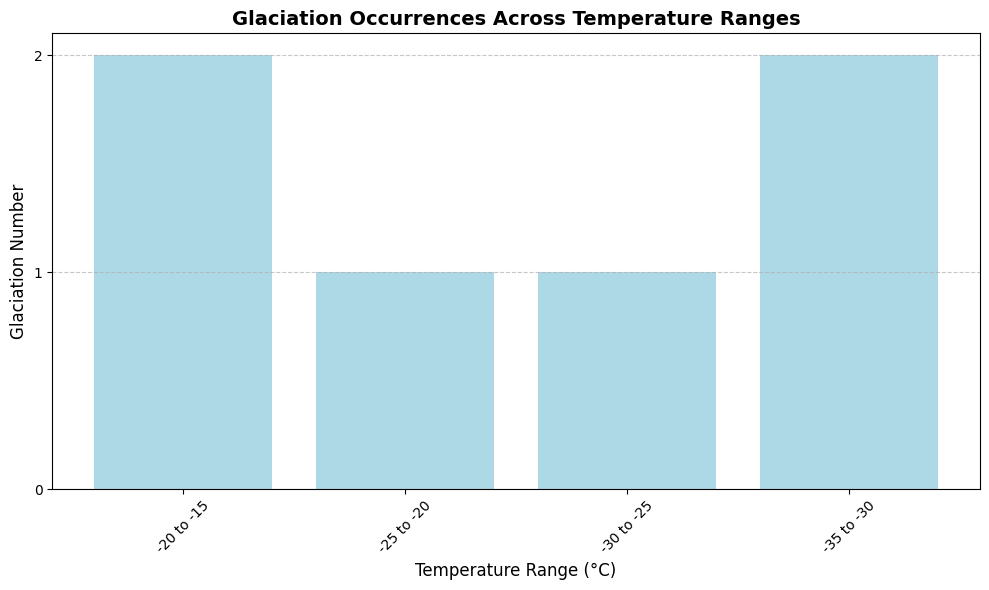

In [ ]:

# Create labels for the x-axis (temperature ranges)
labels = [f"{min_temp_array[i]} to {max_temp_array[i]}" for i in range(3, len(min_temp_array))]

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(labels, glaciation_counter_temp_agg_1[3:], color='lightblue', label="N glaciations")

# Add title and labels
plt.title('Glaciation Occurrences Across Temperature Ranges', fontsize=14, fontweight='bold')
plt.xlabel('Temperature Range (°C)', fontsize=12)
plt.ylabel('Glaciation Number', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add gridlines for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format y-axis to show only integer values
plt.gca().yaxis.get_major_locator().set_params(integer=True)

# Show the plot
plt.tight_layout()
plt.savefig('/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimatior/Result_graphs/glaciation_counter_temp_1.png', dpi=400)
plt.show()

In [ ]:
tmp_bin_array=np.arange(-80,81,10)
# tmp_bin_array

In [ ]:
glaciation_counter_temp_agg_3=np.zeros(len(min_temp_array))
tmp_bins=pd.IntervalIndex.from_arrays(tmp_bin_array[0:-1],tmp_bin_array[1:])
# lat_bin_df= pd.DataFrame(np.zeros(len(tmp_bin_array)-1), index=tmp_bins,columns=["n_clouds"])
lat_bin_df = pd.DataFrame(np.zeros((len(tmp_bin_array) - 1,3)), index=tmp_bins, columns=["n_clouds", "cloud_area_sum", "cloud_px_sum"])


# Drop the biggest and smallest cloud from each group
def drop_min_max(group):
    n_drop=2
    if len(group) > n_drop*2:  # Ensure group has more than two elements
        group = group.sort_values("avg_size[km]")
        return group.iloc[n_drop:-n_drop]  # Drop first and last rows
    return group  # Return an empty DataFrame if not enough rows
combined_df=None
for i in range(len(min_temp_array)):
    agg_fact = agg_fact_list[j]
    min_temp = min_temp_array[i]
    max_temp = max_temp_array[i]
    
    df = cloud_properties_df_list[i][np.where(agg_fact_list == 3)[0][0]]
    
    glaciation_counter_temp_agg_3[i] += (df['is_liq'] & df['is_mix'] & df['is_ice']).astype(bool).sum(axis=0)
    df=df[df['avg_lat'].notna()]
    df=df[df['avg_size[km]'].notna()]
    df["lat_bin"] = pd.cut(df['avg_lat'], tmp_bin_array)
    
    # Filter rows where max_ice_fraction > 0
    filtered_df = df[df["max_ice_fraction"] > ice_cont_crit_frac]
    if combined_df is not None:
        combined_df=pd.concat([combined_df,filtered_df],axis=0)
    else:
        combined_df=filtered_df.copy()
    filtered_df = filtered_df.groupby("lat_bin", group_keys=False).apply(drop_min_max)
    # Group by lat_bin and perform sum on "avg_size[km]"
    
    groups = filtered_df.groupby("lat_bin")
    
    # Update lat_bin_df for filtered data
    # Compute group sums and means
    group_sums_km = groups["avg_size[km]"].sum()
    group_sums_px = groups["avg_size[px]"].sum()

    # Fill NaN values in means with 0 (or another default value if necessary)
    # group_means = group_means.fillna(0)

    # Update lat_bin_df DataFrame
    lat_bin_df["cloud_px_sum"] += group_sums_px
    lat_bin_df["cloud_area_sum"] += group_sums_km
    lat_bin_df["n_clouds"] += groups.size()
    # lat_bin_df["time"]
    # # Debugging Outputs
    # print("sum:", group_sums)
    # print("mean:", group_means)
print(lat_bin_df["cloud_area_sum"]/lat_bin_df["n_clouds"],lat_bin_df["cloud_px_sum"]/lat_bin_df["n_clouds"])
# lat_bin_df["n_clouds"]
# lat_bin_df["n_clouds"]
# pd.cut(df[df["max_ice_fraction"]>0]['avg_lat'].dropna(), tmp_bin_array)


(-80, -70]    4941.455517
(-70, -60]    4600.961400
(-60, -50]    4115.115581
(-50, -40]    4063.301313
(-40, -30]    4094.056660
(-30, -20]    3044.236044
(-20, -10]    3997.495236
(-10, 0]      3641.249844
(0, 10]       6069.644110
(10, 20]      4788.047303
(20, 30]      3260.355526
(30, 40]      4472.922781
(40, 50]      6562.347061
(50, 60]      4474.551327
(60, 70]      5975.083065
(70, 80]      5041.483869
dtype: float64 (-80, -70]    74.880283
(-70, -60]    44.804913
(-60, -50]    29.126498
(-50, -40]    22.900683
(-40, -30]    19.737712
(-30, -20]    13.136849
(-20, -10]    16.160271
(-10, 0]      14.239802
(0, 10]       23.761573
(10, 20]      19.079167
(20, 30]      14.411111
(30, 40]      21.207501
(40, 50]      35.762537
(50, 60]      30.083229
(60, 70]      61.754051
(70, 80]      77.855367
dtype: float64


/scratch/tmp.16922307.dnikolo/ipykernel_3306343/1930954595.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df = filtered_df.groupby("lat_bin", group_keys=False).apply(drop_min_max)
/scratch/tmp.16922307.dnikolo/ipykernel_3306343/1930954595.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = filtered_df.groupby("lat_bin", group_keys=False).apply(drop_min_max)
/scratch/tmp.16922307.dnikolo/ipykernel_3306343/1930954595.py:36: FutureWarning: The default of observed=False is deprecate

In [ ]:
lat_bin_df["median_px_size"]=combined_df.groupby("lat_bin")["avg_size[px]"].median()
lat_bin_df["median_area"]=combined_df.groupby("lat_bin")["avg_size[km]"].median()
lat_bin_df["median_area"]

/scratch/tmp.16922307.dnikolo/ipykernel_3306343/2229431072.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lat_bin_df["median_px_size"]=combined_df.groupby("lat_bin")["avg_size[px]"].median()
/scratch/tmp.16922307.dnikolo/ipykernel_3306343/2229431072.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lat_bin_df["median_area"]=combined_df.groupby("lat_bin")["avg_size[km]"].median()


(-80, -70]    3164.243972
(-70, -60]    3472.371675
(-60, -50]    3385.981823
(-50, -40]    3520.667010
(-40, -30]    2960.019975
(-30, -20]    2863.124444
(-20, -10]    3155.645451
(-10, 0]      2713.273186
(0, 10]       3734.081006
(10, 20]      5105.292566
(20, 30]      3086.595274
(30, 40]      3896.920705
(40, 50]      4872.629149
(50, 60]      3391.044116
(60, 70]      3541.842944
(70, 80]      3397.659840
Name: median_area, dtype: float64

In [ ]:
combined_df["ice_frac_hist"]

30                           [0.0, 0.0, 0.0, 0.125, 0.0]
140    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
260    [0.125, 0.12121212121212122, 0.108695652173913...
269          [0.0, 0.03703703703703709, 0.0, 0.0, 0.125]
290    [0.050000000000000044, 0.0, 0.0, 0.0, 0.0, 0.0...
                             ...                        
396    [0.375, 0.3783783783783784, 0.28, 0.2653061224...
397    [0.85, 0.8863636363636364, 1.0, 0.837837837837...
398    [0.15384615384615385, 0.13636363636363635, 0.6...
401    [0.10526315789473684, 0.0, 0.11904761904761907...
406                 [0.0, 0.0, 0.0, 0.07692307692307687]
Name: ice_frac_hist, Length: 895, dtype: object

In [ ]:
import seaborn as sns



# either palette works
palette=["#9b59b6", "#3498db", "#95a5a6"]
# palette=['blue', 'red', 'green']

sns.lineplot(data=combined_df, y="ice_frac_hist", color = 'r')#dashes=False)# palette=palette, dashes=False)
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

/scratch/tmp.16922307.dnikolo/ipykernel_3306343/882971303.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = combined_df.groupby("lat_bin")


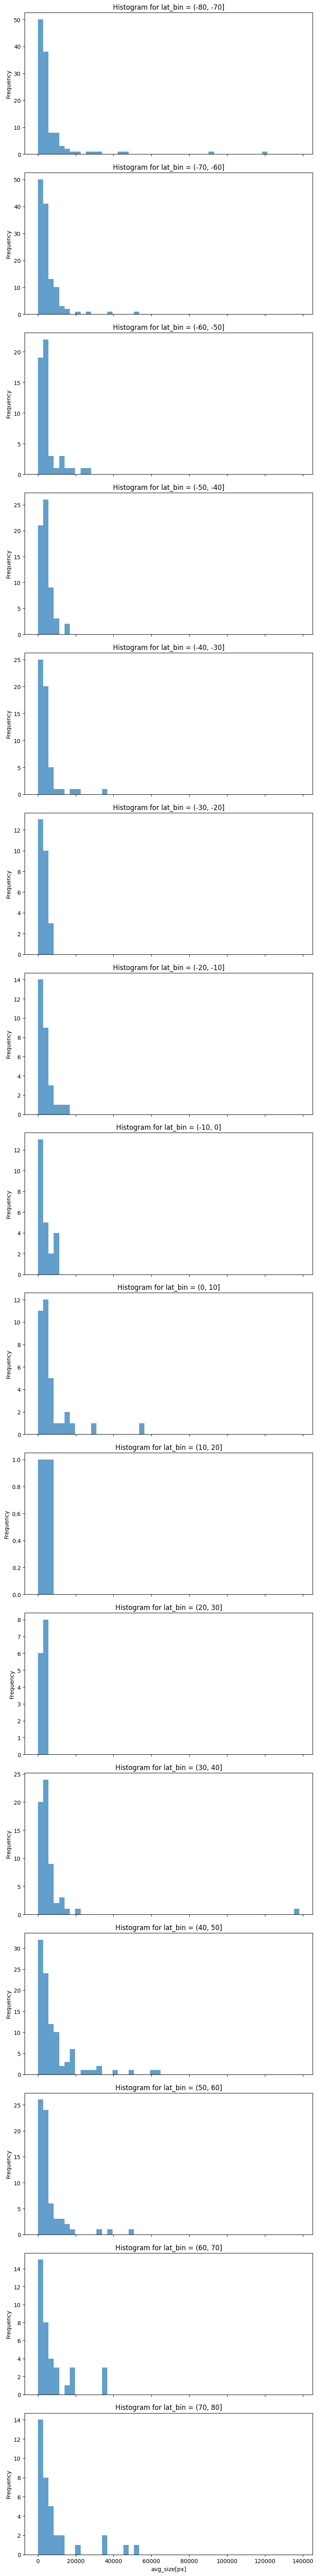

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame setup
# Replace this with your actual combined_df
# combined_df = pd.read_csv("your_file.csv")

# Group by `lat_bin`
groups = combined_df.groupby("lat_bin")
bins=np.linspace(0,combined_df["avg_size[km]"].max(),50)
# combined_df["avg_size[km]"].max()
# Create subplots
fig, axes = plt.subplots(len(groups), 1, figsize=(8, len(groups) * 4), sharex=True)

# Iterate through groups and plot histograms
for (lat_bin, group), ax in zip(groups, axes):
    group["avg_size[km]"].plot(kind='hist', bins=bins, ax=ax, alpha=0.7)
    # ax.hist(group["avg_size[km]"])
    ax.set_title(f'Histogram for lat_bin = {lat_bin}')
    ax.set_xlabel('avg_size[px]')
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
combined_df[combined_df["avg_size[km]"]==combined_df["avg_size[km]"].max()]


,is_liq,is_mix,is_ice,max_water_frac,max_ice_fraction,avg_size[km],max_size[km],min_size[km],avg_size[px],max_size[px],...,track_start_time,track_length,glaciation_start_time,glaciation_end_time,avg_lat,avg_lon,start_ice_fraction,end_ice_fraction,ice_frac_hist,lat_bin
811,True,True,False,0.925032,0.339752,138263.412398,172017.818352,97106.832941,696.833333,868,...,2004-02-01 18:45:00,0 days 01:15:00,None,None,39.271632,-61.105217,"[0.07496823379923756, 0.11866359447004604, 0.2...","[0.22267759562841527, 0.27142857142857146, 0.3...","[0.07496823379923756, 0.11866359447004604, 0.2...","(30, 40]"


In [ ]:
# import xarray as xr
# import matplotlib.pyplot as plt
# ds=xr.load_dataset("/cluster/work/climate/dnikolo/Job_output/T-5-0-agg-3/pixel_path_tracking/20040201.1415_20040201.2000/cloudtracks_20040201_161500.nc")
# plt.imshow(ds["tracknumber"][0,:,:])
# plt.colorbar()

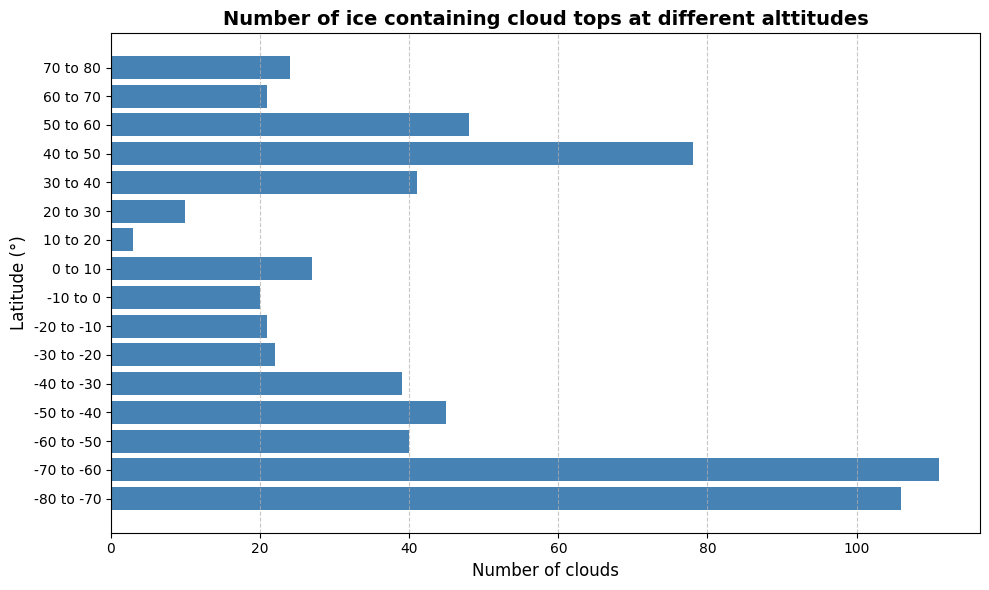

In [ ]:


# Create labels for the y-axis (temperature ranges)
labels = [f"{tmp_bin_array[i]} to {tmp_bin_array[i+1]}" for i in range(len(tmp_bin_array)-1)]

# Create the horizontal bar graph
plt.figure(figsize=(10, 6))

# Add gridlines for better visualization
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Create horizontal bars using plt.barh() instead of plt.bar()
plt.barh(labels, lat_bin_df["n_clouds"], color='#4682B4', label="N glaciations")

# Add title and labels
plt.title('Number of ice containing cloud tops at different alttitudes', fontsize=14, fontweight='bold')
plt.xlabel('Number of clouds', fontsize=12)
plt.ylabel('Latitude (°)', fontsize=12)

# Format x-axis to show only integer values
plt.gca().xaxis.get_major_locator().set_params(integer=True)

# Show the plot
plt.tight_layout()
# plt.savefig('/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimatior/Result_graphs/glaciation_counter_temp_3x3.png', dpi=400)
plt.show()

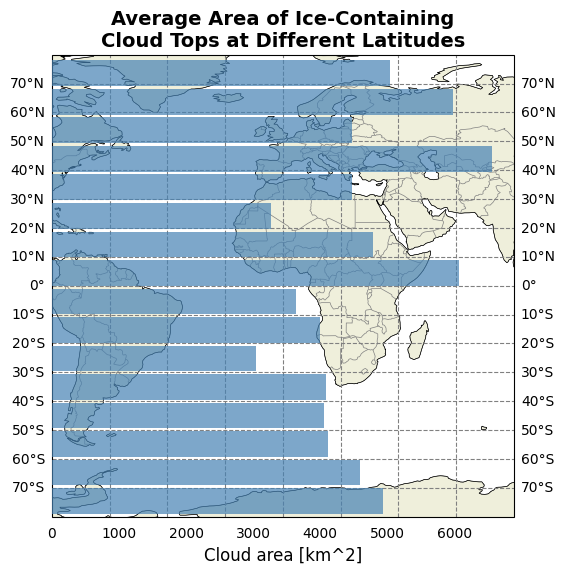

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Dummy data for illustration
# tmp_bin_array = [-80, -60, -40, -20, 0, 20, 40, 60, 80]
# lat_bin_df = {"n_clouds": [5, 15, 20, 10, 25, 15, 10, 5]}

# Calculate midpoints and bin widths
latitudes = [(tmp_bin_array[i] + tmp_bin_array[i + 1] -1 ) / 2 for i in range(len(tmp_bin_array) - 1)]
bin_widths = [tmp_bin_array[i + 1] - tmp_bin_array[i] - 1 for i in range(len(tmp_bin_array) - 1)]

# Create the figure and map axes
fig = plt.figure(figsize=(10, 6))
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_map.set_extent([-80, 80, -80, 80], crs=ccrs.PlateCarree())
ax_map.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax_map.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5)
ax_map.add_feature(cfeature.LAND, facecolor='lightgray')
ax_map.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.2)
#n_steps=10,
# Add gridlines with specified latitude lines
gl = ax_map.gridlines(
    
    draw_labels=True,
    color='gray',
    linestyle='--',
    linewidth=0.8
)
gl.top_labels = False  # Disable labels on the top
gl.bottom_labels = False  # Disable labels on the bottom
# gl.right_labels = False  # Disable labels on the right

# Add specific latitudes for gridlines (including top and bottom latitudes)
latitudes_to_show = tmp_bin_array  # Include all latitude bin boundaries
gl.ylocator = plt.FixedLocator(latitudes_to_show)

# Create the second Axes for the bar chart, sharing the same extent
ax_bar = fig.add_axes(ax_map.get_position(), zorder=2)  # Align with the map
ax_bar.barh(latitudes, lat_bin_df["cloud_area_sum"]/lat_bin_df["n_clouds"], color='#4682B4',
            height=bin_widths, zorder=3, alpha=0.7)  # Use `height` for correct bin widths
# ax_bar.set_xscale("log")
# Remove the background of the bar chart (make transparent)
ax_bar.set_facecolor((1, 1, 1, 0))  # RGBA: white background, fully transparent

# Add title and labels for the bar chart
ax_bar.set_title('Average Area of Ice-Containing\nCloud Tops at Different Latitudes', fontsize=14, fontweight='bold')
ax_bar.set_xlabel('Cloud area [km^2]', fontsize=12)

# Remove the bar graph's y-axis labels
ax_bar.set_yticks([])  # Removes tick marks and labels on y-axis

# Set continuous latitude range for y-axis
ax_bar.set_ylim(tmp_bin_array[0] - 1, tmp_bin_array[-1] + 1)  # Full range of latitude bins

# Format x-axis to show only integer values
# ax_bar.xaxis.get_major_locator().set_params(integer=True)

# Hide axes ticks and spines for the bar chart (optional for cleaner overlay)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['left'].set_visible(False)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.tick_params(left=False, bottom=False)

# Save and show the plot
plt.savefig('/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimatior/Result_graphs/Size_avg_ice_conaining_clouds_by_lat.png', dpi=400)
plt.show()


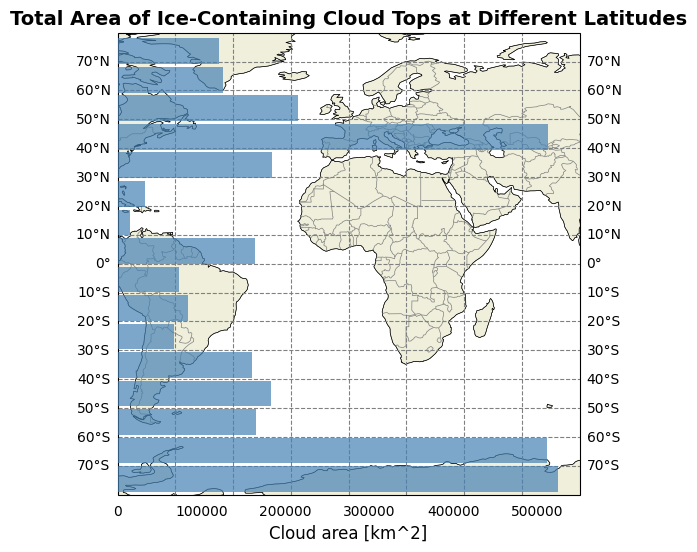

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Dummy data for illustration
# tmp_bin_array = [-80, -60, -40, -20, 0, 20, 40, 60, 80]
# lat_bin_df = {"n_clouds": [5, 15, 20, 10, 25, 15, 10, 5]}

# Calculate midpoints and bin widths
latitudes = [(tmp_bin_array[i] + tmp_bin_array[i + 1] -1 ) / 2 for i in range(len(tmp_bin_array) - 1)]
bin_widths = [tmp_bin_array[i + 1] - tmp_bin_array[i] - 1 for i in range(len(tmp_bin_array) - 1)]

# Create the figure and map axes
fig = plt.figure(figsize=(10, 6))
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_map.set_extent([-80, 80, -80, 80], crs=ccrs.PlateCarree())
ax_map.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax_map.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5)
ax_map.add_feature(cfeature.LAND, facecolor='lightgray')
ax_map.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.2)
#n_steps=10,
# Add gridlines with specified latitude lines
gl = ax_map.gridlines(
    
    draw_labels=True,
    color='gray',
    linestyle='--',
    linewidth=0.8
)
gl.top_labels = False  # Disable labels on the top
gl.bottom_labels = False  # Disable labels on the bottom
# gl.right_labels = False  # Disable labels on the right

# Add specific latitudes for gridlines (including top and bottom latitudes)
latitudes_to_show = tmp_bin_array  # Include all latitude bin boundaries
gl.ylocator = plt.FixedLocator(latitudes_to_show)

# Create the second Axes for the bar chart, sharing the same extent
ax_bar = fig.add_axes(ax_map.get_position(), zorder=2)  # Align with the map
ax_bar.barh(latitudes, lat_bin_df["cloud_area_sum"], color='#4682B4',
            height=bin_widths, zorder=3, alpha=0.7)  # Use `height` for correct bin widths
# ax_bar.set_xscale("log")
# Remove the background of the bar chart (make transparent)
ax_bar.set_facecolor((1, 1, 1, 0))  # RGBA: white background, fully transparent

# Add title and labels for the bar chart
ax_bar.set_title('Total Area of Ice-Containing Cloud Tops at Different Latitudes', fontsize=14, fontweight='bold')
ax_bar.set_xlabel('Cloud area [km^2]', fontsize=12)

# Remove the bar graph's y-axis labels
ax_bar.set_yticks([])  # Removes tick marks and labels on y-axis

# Set continuous latitude range for y-axis
ax_bar.set_ylim(tmp_bin_array[0] - 1, tmp_bin_array[-1] + 1)  # Full range of latitude bins

# Format x-axis to show only integer values
# ax_bar.xaxis.get_major_locator().set_params(integer=True)

# Hide axes ticks and spines for the bar chart (optional for cleaner overlay)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['left'].set_visible(False)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.tick_params(left=False, bottom=False)

# Save and show the plot
plt.savefig('/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimatior/Result_graphs/Size_sum_ice_conaining_clouds_by_lat.png', dpi=400)
plt.show()

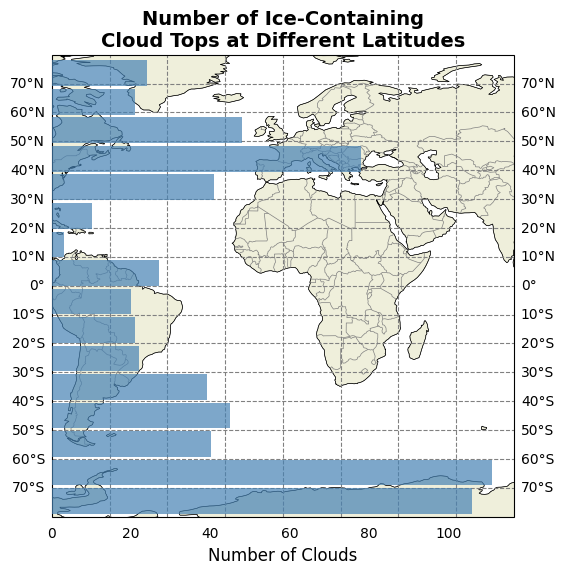

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Dummy data for illustration
# tmp_bin_array = [-80, -60, -40, -20, 0, 20, 40, 60, 80]
# lat_bin_df = {"n_clouds": [5, 15, 20, 10, 25, 15, 10, 5]}

# Calculate midpoints and bin widths
latitudes = [(tmp_bin_array[i] + tmp_bin_array[i + 1] -1 ) / 2 for i in range(len(tmp_bin_array) - 1)]
bin_widths = [tmp_bin_array[i + 1] - tmp_bin_array[i] - 1 for i in range(len(tmp_bin_array) - 1)]

# Create the figure and map axes
fig = plt.figure(figsize=(10, 6))
ax_map = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_map.set_extent([-80, 80, -80, 80], crs=ccrs.PlateCarree())
ax_map.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax_map.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5)
ax_map.add_feature(cfeature.LAND, facecolor='lightgray')
ax_map.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.2)
#n_steps=10,
# Add gridlines with specified latitude lines
gl = ax_map.gridlines(
    
    draw_labels=True,
    color='gray',
    linestyle='--',
    linewidth=0.8
)
gl.top_labels = False  # Disable labels on the top
gl.bottom_labels = False  # Disable labels on the bottom
# gl.right_labels = False  # Disable labels on the right

# Add specific latitudes for gridlines (including top and bottom latitudes)
latitudes_to_show = tmp_bin_array  # Include all latitude bin boundaries
gl.ylocator = plt.FixedLocator(latitudes_to_show)

# Create the second Axes for the bar chart, sharing the same extent
ax_bar = fig.add_axes(ax_map.get_position(), zorder=2)  # Align with the map
ax_bar.barh(latitudes, lat_bin_df["n_clouds"], color='#4682B4',
            height=bin_widths, zorder=3, alpha=0.7)  # Use `height` for correct bin widths

# Remove the background of the bar chart (make transparent)
ax_bar.set_facecolor((1, 1, 1, 0))  # RGBA: white background, fully transparent

# Add title and labels for the bar chart
ax_bar.set_title('Number of Ice-Containing\nCloud Tops at Different Latitudes', fontsize=14, fontweight='bold')
ax_bar.set_xlabel('Number of Clouds', fontsize=12)

# Remove the bar graph's y-axis labels
ax_bar.set_yticks([])  # Removes tick marks and labels on y-axis

# Set continuous latitude range for y-axis
ax_bar.set_ylim(tmp_bin_array[0] - 1, tmp_bin_array[-1] + 1)  # Full range of latitude bins

# Format x-axis to show only integer values
ax_bar.xaxis.get_major_locator().set_params(integer=True)

# Hide axes ticks and spines for the bar chart (optional for cleaner overlay)
ax_bar.spines['top'].set_visible(False)
ax_bar.spines['right'].set_visible(False)
ax_bar.spines['left'].set_visible(False)
ax_bar.spines['bottom'].set_visible(False)
ax_bar.tick_params(left=False, bottom=False)

# Save and show the plot
plt.savefig('/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimatior/Result_graphs/N_ice_conaining_clouds_by_lat.png', dpi=400)
plt.show()



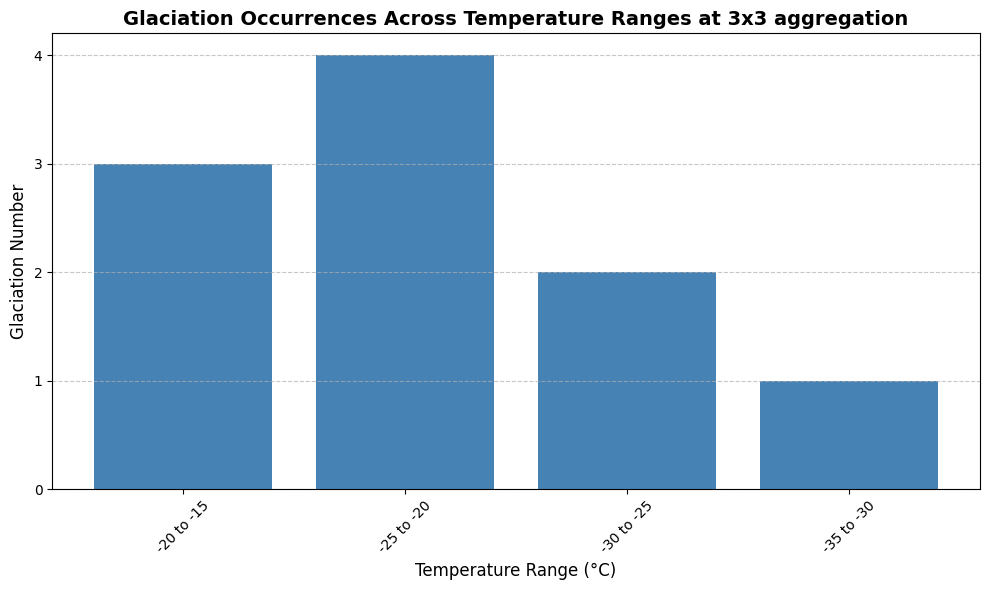

In [ ]:
# Create labels for the x-axis (temperature ranges)
labels = [f"{min_temp_array[i]} to {max_temp_array[i]}" for i in range(3, len(min_temp_array))]

# Create the bar graph
plt.figure(figsize=(10, 6))
# Add gridlines for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.bar(labels, glaciation_counter_temp_agg_3[3:], color='#4682B4', label="N glaciations")

# Add title and labels
plt.title('Glaciation Occurrences Across Temperature Ranges at 3x3 aggregation', fontsize=14, fontweight='bold')
plt.xlabel('Temperature Range (°C)', fontsize=12)
plt.ylabel('Glaciation Number', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)



# Format y-axis to show only integer values
plt.gca().yaxis.get_major_locator().set_params(integer=True)

# Show the plot
plt.tight_layout()
plt.savefig('/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimatior/Result_graphs/glaciation_counter_temp_3x3.png', dpi=400)
plt.show()

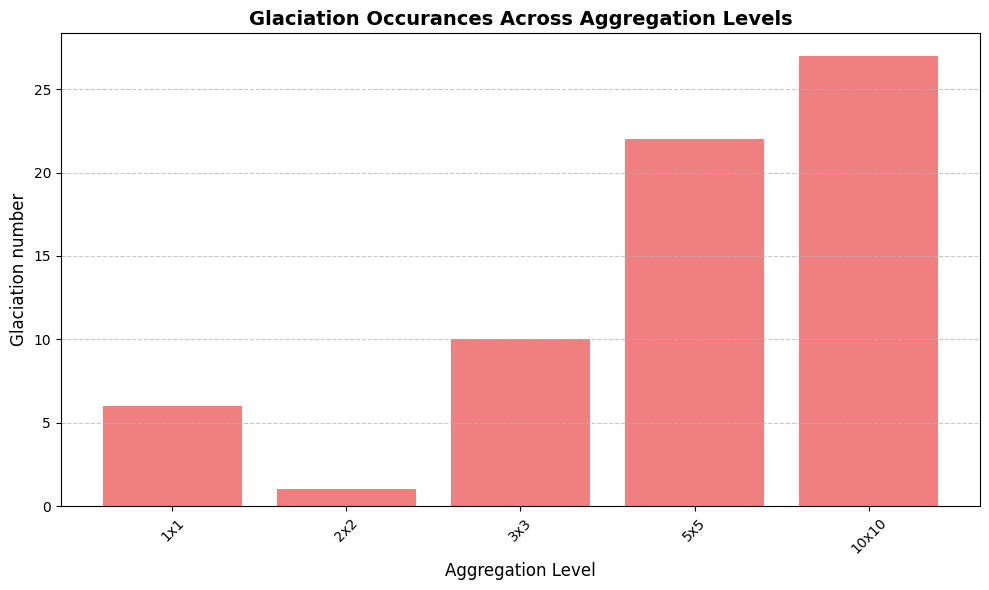

In [ ]:
# # Create labels for the x-axis (temperature ranges)


labels = [f"{agg_fact_list[i]}x{agg_fact_list[i]}" for i in range(len(agg_fact_list))]

# # Create the bar graph
plt.figure(figsize=(10,6))
# plt.bar(labels, n_track_arr[np.where(max_temp_array-min_temp_array==5)], color='skyblue',label="N tracks")
plt.bar(labels, glaciation_counter_strong, color='lightcoral',label="N glaciations")

# Add title and labels
plt.title('Glaciation Occurances Across Aggregation Levels', fontsize=14, fontweight='bold')
plt.xlabel('Aggregation Level', fontsize=12)
plt.ylabel('Glaciation number', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add gridlines for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
# # Show the plot
plt.tight_layout()
plt.savefig(f'/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimatior/Result_graphs/glaciation_counter_strong.png',dpi=400)
plt.show()

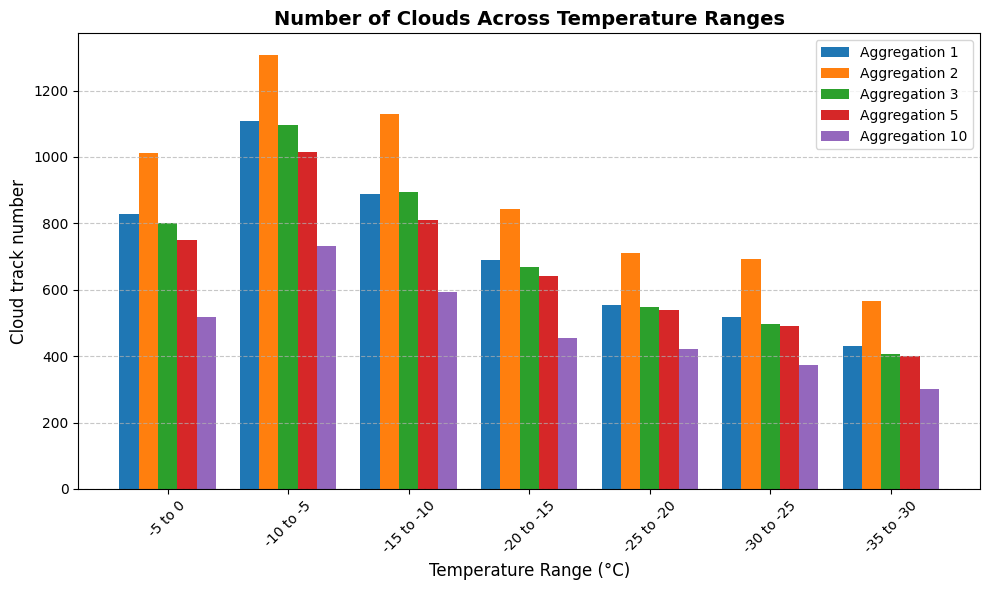

In [ ]:
# Generate labels
labels = [f"{min_temp_array[i]} to {max_temp_array[i]}" for i in range(len(min_temp_array))]
# Set up figure
plt.figure(figsize=(10,6))

# Define bar width and offsets
bar_width = 0.8/len(agg_fact_list)
x = np.arange(len(labels))

# Plot each bar set with an offset
for j in range(len(agg_fact_list)):
    plt.bar(x + j * bar_width, cloud_count[j, :], width=bar_width, label=f"Aggregation {agg_fact_list[j]}")

# Set x-axis labels
plt.xticks(x + (len(agg_fact_list) - 1) * bar_width / 2, labels, rotation=45)

# Add title, labels, and grid
plt.title('Number of Clouds Across Temperature Ranges', fontsize=14, fontweight='bold')
plt.xlabel('Temperature Range (°C)', fontsize=12)
plt.ylabel('Cloud track number', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.savefig("/cluster/work/climate/dnikolo/n2o/Glaciation_time_estimatior/Result_graphs/WG_agg_n_clouds_original_included_11_11_tracknumber.png",dpi=400)
plt.show()


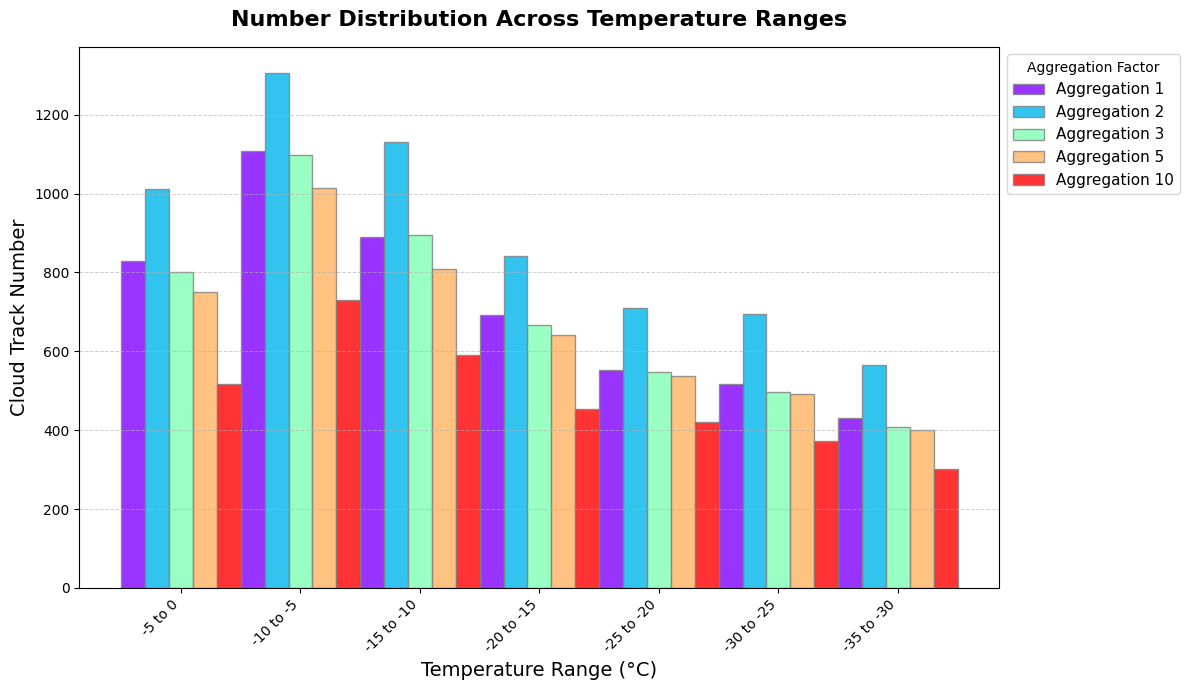

In [ ]:
# Generate labels
labels = [f"{min_temp_array[i]} to {max_temp_array[i]}" for i in range(len(min_temp_array))]

# Set up figure
plt.figure(figsize=(12, 7))

# Define bar width and offsets
bar_width = 0.2
x = np.arange(len(labels))

# Define a rainbow color scheme
colors = plt.cm.rainbow(np.linspace(0, 1, len(agg_fact_list)))

# Plot each bar set with an offset and rainbow color scheme
for j in range(len(agg_fact_list)):
    plt.bar(
        x + j * bar_width, 
        cloud_count[j, :], 
        width=bar_width, 
        color=colors[j], 
        alpha=0.8, 
        edgecolor='grey', 
        label=f"Aggregation {agg_fact_list[j]}"
    )

# Set x-axis labels and align them in the center
plt.xticks(x + (len(agg_fact_list) - 1) * bar_width / 2, labels, rotation=45, ha='right')

# Add title, labels, and a light grid
plt.title('Number Distribution Across Temperature Ranges', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Temperature Range (°C)', fontsize=14)
plt.ylabel('Cloud Track Number', fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)

# Move legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Aggregation Factor", fontsize=11)

# Adjust layout and show plot
plt.tight_layout()
plt.show()